# 09. Pytorch Model Deployment

## 0. Getting Setup

In [10]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [25]:
# Make our device hardward agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using {device} device.")

[INFO] Using cpu device.


## 1. Getting Data

The dataset we're going to use for deployement is Food-101 dataset. It is a dataset containing 101000 images of food items, organized in 101 categories. The dataset is divided into two main folders: one for the training set and one for the test set. Each of these folders contains 101 subfolders, each one corresponding to a category. Each subfolder contains the images of the corresponding category. The images are in jpg format and have a resolution of 512x512 pixels. The dataset is available for download at the following link: https://www.kaggle.com/dansbecker/food-101

But now we will use a smaller version of the dataset, which contains only 3 categories: pizza, steak and sushi. The dataset is available for download at the following link: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip

In [11]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [12]:
# Setup training and testing data paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini : Model Deployement

### 3 questions to ask before building a model :
1. What is my most ideal machine learning model deployment scenario?
2. WHere is mu model going good?
3. How is my model going function in the real world?

#### 1. What is my most ideal machine learning model deployment scenario?
- **Scenario 1**: Model deployed on a smart phone
- **Scenario 2**: Model deployed on a web application
- **Scenario 3**: Model deployed on a server in the cloud

#### 2. Where is my model going to be used?
- **Location 1**: On a smart phone
- **Location 2**: On a web application
- **Location 3**: On a server in the cloud

#### 3. How is my model going to function in the real world?
- **Function 1**: Model is going to be used for real-time inference
- **Function 2**: Model is going to be used for batch inference
- **Function 3**: Model is going to be used for training other models


**FoodVision Mini ideal use case**: A model deployed on a web application for real-time inference.

1. Performs well: 95%+ accuracy on test set
2. Fast: Makes predictions in under 100ms (including pre and post processing) on a CPU or GPU (mobile phone or computer)

## 3. Creating an EfficientNetB3 extraction model

Feature extraction involves taking the pre-trained patterns a model has learned from another dataset and applying it to our own problem.

We can use the `torchvision` library to access a range of pre-trained models. In this case, we'll use the EfficientNet family of models.

EfficientNet is a family of convolutional neural networks that have been trained on ImageNet (a large dataset of images). The EfficientNet models are known for their efficiency and accuracy. We can use the pre-trained EfficientNet models to extract features from our own images.

EfficientNetB3 pretrained model is available in : https://pytorch.org/vision/stable//models/generated/torchvision.models.efficientnet_b3.html#torchvision.models.efficientnet_b3

In [14]:
import torchvision

# 1. Setup pretrained EfficientNetB3 weights
efficientb3_weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT

# 2. Get EfficientNetB3 transforms
efficientb3_transforms = efficientb3_weights.transforms()

# 3. Setup pretrained EfficientNetB3 model
efficientb3_model = torchvision.models.efficientnet_b3(weights=efficientb3_weights)

# 4. Freeze all layers in the base model
for param in efficientb3_model.parameters():
    param.requires_grad = False

In [15]:
efficientb3_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [18]:
# Get the summary of the model
from torchinfo import summary

# summary(efficientb3_model, input_size=(1, 3, 224, 224))


In [19]:
efficientb3_model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1000, bias=True)
)

In [22]:
efficientb3_model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features=1536, out_features=3, bias=True)
)

efficientb3_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

### 3.1 Creating a function to make an EfficientNetB3 model

In [3]:
def create_efficientnetb3_model(num_classes: int = 3):
    """Creates an instance of EfficientNetB3 model with a custom final layer.

    Args:
        num_classes (int): Number of classes in the final layer of the model. Defaults to 3.

    Returns:
        nn.Module: A customised version of the EfficientNetB3 model with a custom final layer.
        Transforms: Image transformations to be used with the model.
    """

    # 1. Setup pretrained EfficientNetB3 weights
    weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT

    # 2. Get EfficientNetB3 transforms
    transforms = weights.transforms()

    # 3. Setup pretrained EfficientNetB3 model
    mdoel = torchvision.models.efficientnet_b3(weights=weights)

    # 4. Freeze all layers in the base model
    for param in mdoel.parameters():
        param.requires_grad = False

    # 5. Change the final layer to output `num_classes` classes
    mdoel.classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_features=1536, out_features=num_classes, bias=True)
    )

    return mdoel, transforms

In [14]:
efficientb3_model, efficientb3_transforms = create_efficientnetb3_model(num_classes=3)

efficientb3_transforms

ImageClassification(
    crop_size=[300]
    resize_size=[320]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 3.2 Creating a DataLoader using the EfficientNetB3 model's transforms

In [15]:
from going_modular import data_setup

# Define the training and testing dataloaders
train_data, test_data, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                       test_dir=test_dir,
                                                       transform=efficientb3_transforms,
                                                       batch_size=32)

In [16]:
len(train_data), len(test_data), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 3.3 Training EfficientNetB3 model

In [17]:
# compile the model
efficientb3_model_compiled = torch.compile(efficientb3_model)

/media/etudiant/New D/PyTorchSRC/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [59]:
from going_modular import engine

# Set random seed
set_seeds(seed=42)

# Create a model, specify the device (GPU) and number of classes
efficientb3_model = efficientb3_model.to(device)

# Create an optimizer and loss function
optimizer = torch.optim.Adam(efficientb3_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Train the model
history = engine.train(model=efficientb3_model,
                              train_dataloader=train_data,
                              test_dataloader=test_data,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=50,
                              device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:52<42:57, 52.60s/it]

Epoch: 1 | train_loss: 0.3590 | train_acc: 0.9250 | test_loss: 0.3271 | test_acc: 0.9659


  4%|▍         | 2/50 [01:51<45:05, 56.36s/it]

Epoch: 2 | train_loss: 0.3023 | train_acc: 0.9458 | test_loss: 0.2876 | test_acc: 0.9784


  6%|▌         | 3/50 [02:50<45:14, 57.75s/it]

Epoch: 3 | train_loss: 0.2813 | train_acc: 0.9375 | test_loss: 0.2646 | test_acc: 0.9722


  8%|▊         | 4/50 [03:49<44:35, 58.15s/it]

Epoch: 4 | train_loss: 0.3135 | train_acc: 0.8833 | test_loss: 0.2394 | test_acc: 0.9722


 10%|█         | 5/50 [04:49<43:55, 58.57s/it]

Epoch: 5 | train_loss: 0.2660 | train_acc: 0.9208 | test_loss: 0.2554 | test_acc: 0.9597


 12%|█▏        | 6/50 [05:48<43:12, 58.93s/it]

Epoch: 6 | train_loss: 0.2473 | train_acc: 0.9375 | test_loss: 0.2377 | test_acc: 0.9659


 14%|█▍        | 7/50 [07:06<46:44, 65.22s/it]

Epoch: 7 | train_loss: 0.2981 | train_acc: 0.9250 | test_loss: 0.2223 | test_acc: 0.9659


 16%|█▌        | 8/50 [08:27<49:11, 70.27s/it]

Epoch: 8 | train_loss: 0.3136 | train_acc: 0.9208 | test_loss: 0.2051 | test_acc: 0.9659


 18%|█▊        | 9/50 [09:49<50:23, 73.75s/it]

Epoch: 9 | train_loss: 0.2646 | train_acc: 0.9000 | test_loss: 0.2229 | test_acc: 0.9506


 20%|██        | 10/50 [11:14<51:27, 77.19s/it]

Epoch: 10 | train_loss: 0.2191 | train_acc: 0.9479 | test_loss: 0.1980 | test_acc: 0.9784


 22%|██▏       | 11/50 [12:35<51:01, 78.51s/it]

Epoch: 11 | train_loss: 0.2015 | train_acc: 0.9500 | test_loss: 0.1926 | test_acc: 0.9784


 24%|██▍       | 12/50 [13:55<49:55, 78.83s/it]

Epoch: 12 | train_loss: 0.1782 | train_acc: 0.9604 | test_loss: 0.2003 | test_acc: 0.9631


 26%|██▌       | 13/50 [14:56<45:19, 73.50s/it]

Epoch: 13 | train_loss: 0.2128 | train_acc: 0.9354 | test_loss: 0.1897 | test_acc: 0.9784


 28%|██▊       | 14/50 [15:55<41:31, 69.21s/it]

Epoch: 14 | train_loss: 0.1832 | train_acc: 0.9604 | test_loss: 0.1804 | test_acc: 0.9693


 30%|███       | 15/50 [16:55<38:46, 66.46s/it]

Epoch: 15 | train_loss: 0.1752 | train_acc: 0.9604 | test_loss: 0.1887 | test_acc: 0.9784


 32%|███▏      | 16/50 [17:55<36:31, 64.47s/it]

Epoch: 16 | train_loss: 0.1640 | train_acc: 0.9604 | test_loss: 0.1705 | test_acc: 0.9722


 34%|███▍      | 17/50 [18:57<35:03, 63.74s/it]

Epoch: 17 | train_loss: 0.2274 | train_acc: 0.9396 | test_loss: 0.1707 | test_acc: 0.9722


 36%|███▌      | 18/50 [19:58<33:31, 62.87s/it]

Epoch: 18 | train_loss: 0.1752 | train_acc: 0.9500 | test_loss: 0.1789 | test_acc: 0.9659


 38%|███▊      | 19/50 [21:00<32:19, 62.56s/it]

Epoch: 19 | train_loss: 0.2513 | train_acc: 0.8875 | test_loss: 0.1750 | test_acc: 0.9659


 40%|████      | 20/50 [22:07<31:59, 63.97s/it]

Epoch: 20 | train_loss: 0.2120 | train_acc: 0.9646 | test_loss: 0.1743 | test_acc: 0.9784


 42%|████▏     | 21/50 [23:30<33:35, 69.49s/it]

Epoch: 21 | train_loss: 0.1753 | train_acc: 0.9542 | test_loss: 0.1686 | test_acc: 0.9784


 44%|████▍     | 22/50 [24:42<32:49, 70.33s/it]

Epoch: 22 | train_loss: 0.1838 | train_acc: 0.9396 | test_loss: 0.1729 | test_acc: 0.9659


 46%|████▌     | 23/50 [25:51<31:28, 69.95s/it]

Epoch: 23 | train_loss: 0.1546 | train_acc: 0.9604 | test_loss: 0.1697 | test_acc: 0.9659


 48%|████▊     | 24/50 [26:53<29:15, 67.52s/it]

Epoch: 24 | train_loss: 0.2407 | train_acc: 0.9333 | test_loss: 0.1629 | test_acc: 0.9506


 50%|█████     | 25/50 [27:53<27:13, 65.36s/it]

Epoch: 25 | train_loss: 0.1451 | train_acc: 0.9750 | test_loss: 0.1670 | test_acc: 0.9756


 52%|█████▏    | 26/50 [29:07<27:07, 67.81s/it]

Epoch: 26 | train_loss: 0.1509 | train_acc: 0.9729 | test_loss: 0.1563 | test_acc: 0.9784


 54%|█████▍    | 27/50 [30:22<26:48, 69.93s/it]

Epoch: 27 | train_loss: 0.1959 | train_acc: 0.9292 | test_loss: 0.1469 | test_acc: 0.9659


 56%|█████▌    | 28/50 [31:26<25:02, 68.31s/it]

Epoch: 28 | train_loss: 0.2149 | train_acc: 0.8917 | test_loss: 0.1722 | test_acc: 0.9540


 58%|█████▊    | 29/50 [32:27<23:05, 65.98s/it]

Epoch: 29 | train_loss: 0.2640 | train_acc: 0.9146 | test_loss: 0.1752 | test_acc: 0.9449


 60%|██████    | 30/50 [33:41<22:51, 68.55s/it]

Epoch: 30 | train_loss: 0.1430 | train_acc: 0.9729 | test_loss: 0.1518 | test_acc: 0.9597


 62%|██████▏   | 31/50 [35:03<22:58, 72.56s/it]

Epoch: 31 | train_loss: 0.1321 | train_acc: 0.9646 | test_loss: 0.1530 | test_acc: 0.9631


 64%|██████▍   | 32/50 [36:10<21:15, 70.83s/it]

Epoch: 32 | train_loss: 0.1715 | train_acc: 0.9500 | test_loss: 0.1490 | test_acc: 0.9631


 66%|██████▌   | 33/50 [37:09<19:04, 67.31s/it]

Epoch: 33 | train_loss: 0.1371 | train_acc: 0.9688 | test_loss: 0.1690 | test_acc: 0.9386


 68%|██████▊   | 34/50 [38:12<17:37, 66.11s/it]

Epoch: 34 | train_loss: 0.1843 | train_acc: 0.9333 | test_loss: 0.1543 | test_acc: 0.9568


 70%|███████   | 35/50 [39:12<16:02, 64.16s/it]

Epoch: 35 | train_loss: 0.1138 | train_acc: 0.9750 | test_loss: 0.1480 | test_acc: 0.9631


 72%|███████▏  | 36/50 [40:27<15:43, 67.36s/it]

Epoch: 36 | train_loss: 0.1124 | train_acc: 0.9792 | test_loss: 0.1477 | test_acc: 0.9631


 74%|███████▍  | 37/50 [41:42<15:06, 69.73s/it]

Epoch: 37 | train_loss: 0.1100 | train_acc: 0.9771 | test_loss: 0.1701 | test_acc: 0.9324


 76%|███████▌  | 38/50 [42:37<13:04, 65.34s/it]

Epoch: 38 | train_loss: 0.1216 | train_acc: 0.9729 | test_loss: 0.1404 | test_acc: 0.9722


 78%|███████▊  | 39/50 [43:33<11:26, 62.45s/it]

Epoch: 39 | train_loss: 0.1316 | train_acc: 0.9729 | test_loss: 0.1494 | test_acc: 0.9631


 80%|████████  | 40/50 [44:28<10:02, 60.22s/it]

Epoch: 40 | train_loss: 0.1255 | train_acc: 0.9708 | test_loss: 0.1511 | test_acc: 0.9631


 82%|████████▏ | 41/50 [45:24<08:50, 58.94s/it]

Epoch: 41 | train_loss: 0.1056 | train_acc: 0.9771 | test_loss: 0.1514 | test_acc: 0.9477


 84%|████████▍ | 42/50 [46:19<07:42, 57.83s/it]

Epoch: 42 | train_loss: 0.2296 | train_acc: 0.9437 | test_loss: 0.1545 | test_acc: 0.9693


 86%|████████▌ | 43/50 [47:15<06:41, 57.34s/it]

Epoch: 43 | train_loss: 0.1878 | train_acc: 0.9417 | test_loss: 0.1601 | test_acc: 0.9415


 88%|████████▊ | 44/50 [48:11<05:40, 56.79s/it]

Epoch: 44 | train_loss: 0.1098 | train_acc: 0.9750 | test_loss: 0.1611 | test_acc: 0.9540


 90%|█████████ | 45/50 [49:06<04:41, 56.30s/it]

Epoch: 45 | train_loss: 0.1155 | train_acc: 0.9688 | test_loss: 0.1347 | test_acc: 0.9722


 92%|█████████▏| 46/50 [50:01<03:43, 55.81s/it]

Epoch: 46 | train_loss: 0.1089 | train_acc: 0.9771 | test_loss: 0.1495 | test_acc: 0.9540


 94%|█████████▍| 47/50 [50:56<02:46, 55.64s/it]

Epoch: 47 | train_loss: 0.1076 | train_acc: 0.9833 | test_loss: 0.1352 | test_acc: 0.9631


 96%|█████████▌| 48/50 [51:51<01:50, 55.46s/it]

Epoch: 48 | train_loss: 0.1261 | train_acc: 0.9729 | test_loss: 0.1517 | test_acc: 0.9386


 98%|█████████▊| 49/50 [52:40<00:53, 53.67s/it]

Epoch: 49 | train_loss: 0.1180 | train_acc: 0.9875 | test_loss: 0.1351 | test_acc: 0.9722


100%|██████████| 50/50 [53:32<00:00, 64.24s/it]

Epoch: 50 | train_loss: 0.1706 | train_acc: 0.9542 | test_loss: 0.1422 | test_acc: 0.9631


### 3.4 Inspect the model's training history

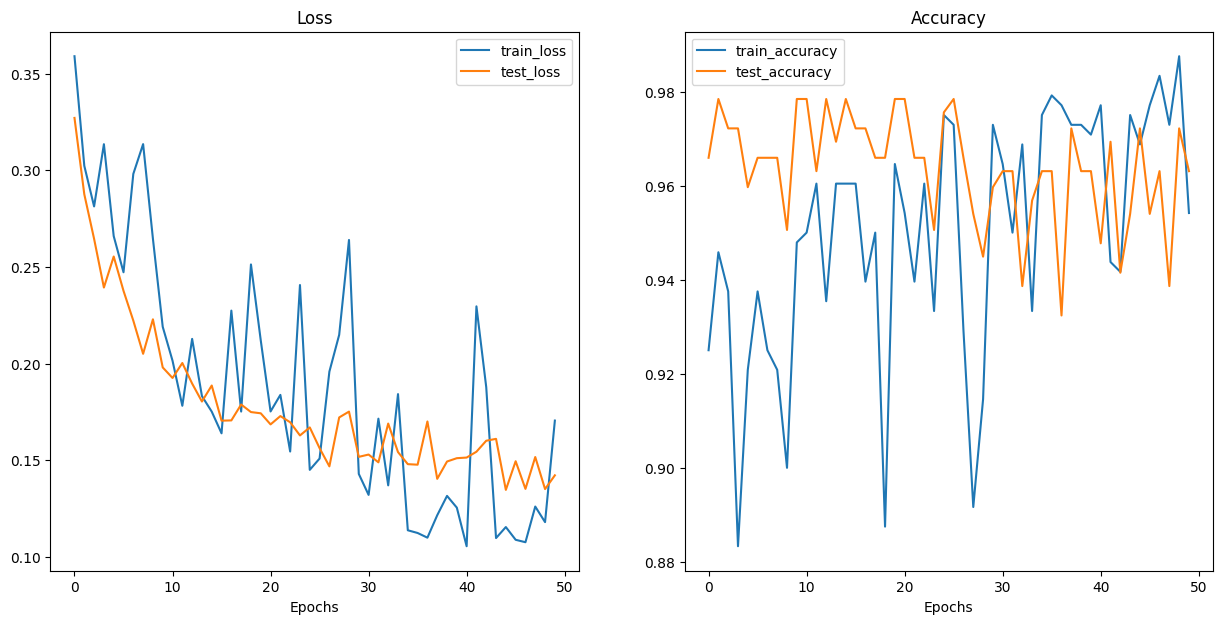

In [60]:
from helper_functions import plot_loss_curves
efficientb3_history = history
plot_loss_curves(efficientb3_history)

### 3.5 Save our model

In [61]:
import os

# Create the directory if it doesn't exist
os.makedirs("models", exist_ok=True)

torch.save(efficientb3_model.state_dict(), "models/efficientnetb3_model_50.pt")

### 3.6 Inspecting the size of the model

In [58]:
# Get the size of the model
import os

model_path = "models/efficientnetb3_model.pt"
model_size = os.path.getsize(model_path) / 1e6
print(f"Model size: {model_size} MB")   


Model size: 43.35784 MB


In [62]:
# Get the size of the model
import os

model_path = "models/efficientnetb3_model_50.pt"
model_size = os.path.getsize(model_path) / 1e6
print(f"Model size: {model_size} MB")   

Model size: 43.35983 MB


## 4. Creating a ViT model

In [65]:
vit = torchvision.models.vit_b_32()

vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [34]:
def create_vit_model(num_classes: int = 3):
    """Creates an instance of Vision Transformer (ViT) model with a custom final layer.

    Args:
        num_classes (int): Number of classes in the final layer of the model. Defaults to 3.

    Returns:
        nn.Module: A customised version of the Vision Transformer (ViT) model with a custom final layer.

    """

    # Create ViT_B_32 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_32_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_32(weights=weights)

    # Freeze all layers in the base model
    for param in model.parameters():
        param.requires_grad = False

    # Change the final layer to output num_classes classes
    model.heads = nn.Sequential(nn.Linear(in_features=768, 
                                          out_features=num_classes, 
                                          bias=True))
    
    return model, transforms


In [36]:
vit, vit_transforms = create_vit_model(num_classes=3)

In [74]:
# Get the summary of the model
from torchinfo import summary

# summary(vit, 
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "kernel_size", "trainable"],
#         col_width=18,
#         row_settings=["var_names"])

### 4.1 Create DataLoaders for ViT model

In [37]:
# Setup ViT DataLoaders

from going_modular import data_setup

# Define the training and testing dataloaders
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                       test_dir=test_dir,
                                                       transform=vit_transforms,
                                                       batch_size=32)

len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Train the ViT model

In [80]:
from going_modular import engine

# Set random seed
set_seeds(seed=42)

# Create a model, specify the device (GPU) and number of classes
vit = vit.to(device)

# Create an optimizer and loss function
optimizer = torch.optim.Adam(vit.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Train the model
history_vit = engine.train(model=vit,
                              train_dataloader=train_dataloader_vit,
                              test_dataloader=test_dataloader_vit,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=10,
                              device=device)

 10%|█         | 1/10 [00:22<03:26, 22.97s/it]

Epoch: 1 | train_loss: 0.7155 | train_acc: 0.7333 | test_loss: 0.3051 | test_acc: 0.9290


 20%|██        | 2/10 [00:45<03:01, 22.68s/it]

Epoch: 2 | train_loss: 0.2749 | train_acc: 0.9042 | test_loss: 0.2083 | test_acc: 0.9443


 30%|███       | 3/10 [01:06<02:32, 21.80s/it]

Epoch: 3 | train_loss: 0.1876 | train_acc: 0.9500 | test_loss: 0.1650 | test_acc: 0.9506


 40%|████      | 4/10 [01:29<02:13, 22.24s/it]

Epoch: 4 | train_loss: 0.1456 | train_acc: 0.9625 | test_loss: 0.1518 | test_acc: 0.9625


 50%|█████     | 5/10 [01:52<01:52, 22.55s/it]

Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9667 | test_loss: 0.1404 | test_acc: 0.9534


 60%|██████    | 6/10 [02:18<01:35, 23.77s/it]

Epoch: 6 | train_loss: 0.1419 | train_acc: 0.9375 | test_loss: 0.1297 | test_acc: 0.9688


 70%|███████   | 7/10 [02:44<01:13, 24.62s/it]

Epoch: 7 | train_loss: 0.0983 | train_acc: 0.9750 | test_loss: 0.1255 | test_acc: 0.9688


 80%|████████  | 8/10 [03:09<00:49, 24.79s/it]

Epoch: 8 | train_loss: 0.1142 | train_acc: 0.9458 | test_loss: 0.1130 | test_acc: 0.9750


 90%|█████████ | 9/10 [03:32<00:24, 24.03s/it]

Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9812 | test_loss: 0.1136 | test_acc: 0.9659


100%|██████████| 10/10 [03:58<00:00, 23.81s/it]

Epoch: 10 | train_loss: 0.0748 | train_acc: 0.9875 | test_loss: 0.1096 | test_acc: 0.9750


### 4.3 Plot the loss cuve of the ViT model

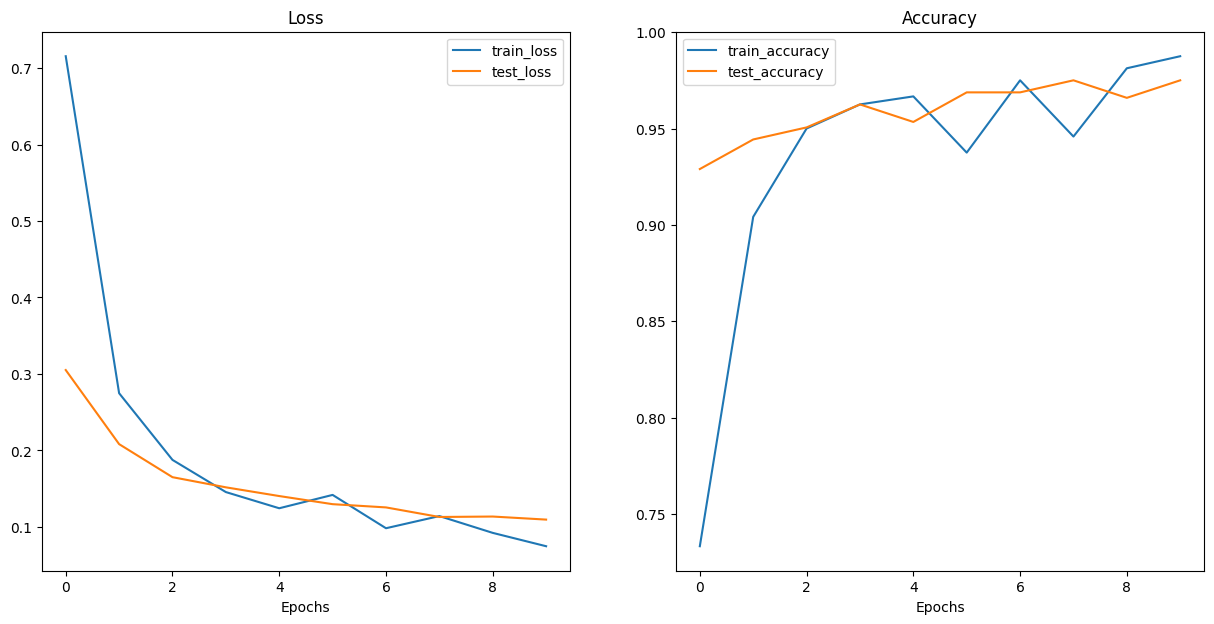

In [81]:
from helper_functions import plot_loss_curves

plot_loss_curves(history_vit)

### 4.4 Save our ViT model

In [83]:
torch.save(vit, "models/vit_model_10.pt")

### 4.5 Checking the size of our ViT model

In [100]:
import os

vit_path = "models/vit_model_10.pt"

size = os.path.getsize(vit_path) / 1e6
print(f"[INFO] SIze of our ViT model : {size} MB")

[INFO] SIze of our ViT model : 349.913102 MB


## 5. Making prediction with our models and timing them

Our goals:
1. Performs well (95%+ accuracy)
2. Fast (120+FPS)

In [23]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[-6:]


[PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2012780.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2274102.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2352914.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2378406.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2394442.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/2416569.jpg')]

### 5.1 Creating a function to make prediction across the test dataset

Now we've got a list of our test image paths, let's get to work on our `make_prediction()` function:

1. Create a function that takes a list of paths, a trained PyTorch model, a series of transforms (to prepare images), a list of target class names and a target device.

2. Create an empty list to store prediction dictionaries (we want the function to return a list of dictionaries, one for each prediction).

3. Loop through the target input paths (steps 4-14 will happen inside the loop).

4. Create an empty dictionary for each iteration in the loop to store prediction values per sample.

5. Get the sample path and ground truth class name (we can do this by inferring the class from the path).

6. Start the prediction timer using Python's `timeit.default_timer()`.

7. Open the image using PIL.Image.open(path).

8. Transform the image so it's capable of being used with the target model as well as add a batch dimension and send the image to the target device.

9. Prepare the model for inference by sending it to the target device and turning on eval() mode.

10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and calculate the prediction probability using `torch.softmax()` and the target label using torch.argmax().

11. Add the prediction probability and prediction class to the prediction dictionary created in step 4. Also make sure the prediction probability is on the CPU so it can be used with non-GPU libraries such as NumPy and pandas for later inspection.

12. End the prediction timer started in step 6 and add the time to the prediction dictionary created in step 4.

13. See if the predicted class matches the ground truth class from step 5 and add the result to the prediction dictionary created in step 4.
14. Append the updated prediction dictionary to the empty list of predictions created in step 2.

15. Return the list of prediction dictionaries.

A bunch of steps, but nothing we can't handle!

Let's do it.



In [102]:
from typing import Dict, List
import pathlib
import torch

from tqdm.auto import tqdm
from timeit import default_timer as timer
from PIL import Image

import torchvision.transforms.v2


def make_prediction(paths: List[pathlib.Path],
                    model: torch.nn.Module,
                    transform: torchvision.transforms.v2,
                    class_names: List[str],
                    device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    
    ## 1. Create an empty list (can return a full list of all predictions later)
    pred_list = []

    # 2. Loop through the target input paths
    for path in tqdm(paths):

        # 3. Create an empty dictionnary for each epoch
        pred_dict = {}

        # 4. Get the sample path and ground truth class from filepath
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 5. Start the prediction timer
        start_time = timer()

        # 6. Open the image using `PIL.Image.open(path)`
        image = Image.open(path)

        # 7. Transform the image using the model tranform
        transformed_image = transform(image).unsqueeze(0).to(device)

        # 8. Prepare the model for inference 
        model = model.to(device)
        model.eval()

        # 9. Turn `torch.inference_model()`
        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]

        # 10. Add pred prob + pred class to empty dictionnary
        pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
        pred_dict["pred_class"] = pred_class

        # 11. End the timer
        end_time = timer()
        pred_dict["time_for_pred"] = round(end_time - start_time, 4)

        # 12. See if the prediction is correct
        pred_dict["correct"] = pred_class == class_name

        ## 13. Append the updated prediction dictionnary
        pred_list.append(pred_dict)

    return pred_list

### 5.2 Making and timing predictions with EfficientNetB3

In [108]:
efficient_net_b3_predictions = make_prediction(test_data_paths,
                                               efficientb3_model,
                                               efficientb3_transforms,
                                               class_names,)

100%|██████████| 150/150 [00:18<00:00,  8.17it/s]


In [109]:
efficient_net_b3_predictions

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3174637.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.997,
  'pred_class': 'pizza',
  'time_for_pred': 0.302,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3375083.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9911,
  'pred_class': 'pizza',
  'time_for_pred': 0.1669,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3376617.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.5886,
  'pred_class': 'pizza',
  'time_for_pred': 0.1018,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3486640.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9999,
  'pred_class': 'pizza',
  'time_for_pred': 0.0964,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3497151.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9909,
  'pred_class': 'pizza',
  'time_for_pr

In [110]:
import pandas as pd

effnetb3_test_pred_df = pd.DataFrame(efficient_net_b3_predictions)

effnetb3_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9970,pizza,0.3020,True
1,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9911,pizza,0.1669,True
2,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.5886,pizza,0.1018,True
3,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9999,pizza,0.0964,True
4,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9909,pizza,0.1304,True


In [111]:
# Check number of correct prediction
effnetb3_test_pred_df.correct.value_counts()

correct
True     145
False      5
Name: count, dtype: int64

In [116]:
# Find the average time per prediction
effnetb3_average_time_prediction = round(effnetb3_test_pred_df.time_for_pred.mean(), 10)
print(f"Average time for prediction per image : {effnetb3_average_time_prediction}")

Average time for prediction per image : 0.1199666667


### 5.3 Making and timing prediction for our ViT model

In [118]:
vit_predictions = make_prediction(test_data_paths,
                                               vit,
                                               vit_transforms,
                                               class_names,)

100%|██████████| 150/150 [00:12<00:00, 12.00it/s]


In [119]:
vit_predictions

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3174637.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9972,
  'pred_class': 'pizza',
  'time_for_pred': 0.0855,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3375083.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9991,
  'pred_class': 'pizza',
  'time_for_pred': 0.1037,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3376617.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9983,
  'pred_class': 'pizza',
  'time_for_pred': 0.1001,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3486640.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9995,
  'pred_class': 'pizza',
  'time_for_pred': 0.086,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3497151.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9934,
  'pred_class': 'pizza',
  'time_for_p

In [120]:
import pandas as pd

vit_predictions_df = pd.DataFrame(vit_predictions)

vit_predictions_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9972,pizza,0.0855,True
1,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9991,pizza,0.1037,True
2,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9983,pizza,0.1001,True
3,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9995,pizza,0.0860,True
4,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9934,pizza,0.0893,True


In [121]:
# Check number of correct prediction
vit_predictions_df.correct.value_counts()

correct
True     146
False      4
Name: count, dtype: int64

In [122]:
# Find the average time per prediction
vit_average_time_prediction = round(vit_predictions_df.time_for_pred.mean(), 10)
print(f"Average time for prediction per image : {vit_average_time_prediction}")

Average time for prediction per image : 0.08194


In [38]:
import torch

# Load the model
efficientb3_model = torch.load("models/efficientnetb3_model_50.pt")
vit_model = torch.load("models/vit_model_10.pt")


/tmp/ipykernel_508989/1337340981.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efficientb3_model = torch.load("models/efficientnetb3_model_50.pt")
/tmp/ipykernel_50898

## 6. Bringing Our models to live

In [1]:
# Import/install Gradio 
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr
    
print(f"Gradio version: {gr.__version__}")

/media/etudiant/New D/PyTorchSRC/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Gradio version: 5.0.0


### 6.1 Creating a function to map our inputs and outputs

In [18]:
from torch import nn
import torch

# Load the model architecture
efficientb3_model_cpu = create_efficientnetb3_model(num_classes=3)[0]

# Load the state dictionary
efficientb3_model_cpu.load_state_dict(torch.load("models/efficientnetb3_model_50.pt"))

# Put our model on the cpu
efficientb3_model_cpu = efficientb3_model_cpu.to("cpu")

# Check the device of the model's parameters
next(efficientb3_model_cpu.parameters()).device

/tmp/ipykernel_15421/4120138208.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efficientb3_model_cpu.load_state_dict(torch.load("models/efficientnetb3_model_50.pt"))


device(type='cpu')

#### Let's create a function called `predict()` which will take an image as input and return the prediction

In [19]:
import torch
from typing import Dict, Tuple


def predict(img) -> Tuple[Dict, float]:
    # Start timer
    start_time = timer()

    # Transform the image
    img = efficientb3_transforms(img).unsqueeze(0)

    # Put our model in evaluation mode
    efficientb3_model_cpu.eval()
    with torch.inference_mode():
        # Make a prediction
        pred_logit = efficientb3_model_cpu(img)
        pred = torch.softmax(pred_logit, dim=1)

    
    # Create a prediction label and prediction probability dictionary
    pred_label_and_prob = {class_names[i]: float(pred[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    end_time = timer()
    prediction_time = round(end_time - start_time, 5)

    return pred_label_and_prob, prediction_time


In [20]:
class_names

['pizza', 'steak', 'sushi']

In [24]:
import random
from PIL import Image
from timeit import default_timer as timer

# Get list of all test image filepaths
test_image_paths = [path for path in test_data_paths]

# Randomly select an image path
random_image_path = random.choice(test_image_paths)
print(random_image_path)

# Open the target image
random_image = Image.open(random_image_path)
print(f"Image shape: {random_image.size}")

# Make a prediction on the random image
random_image_prediction, random_image_prediction_time = predict(random_image)

print(random_image_prediction, random_image_prediction_time)

data/pizza_steak_sushi_20_percent/test/steak/1972463.jpg
Image shape: (512, 512)
{'pizza': 0.00010360943269915879, 'steak': 0.9989141225814819, 'sushi': 0.0009823235450312495} 0.23627


### 6.3 Creating a list of images examples for Gradio

In [25]:
# Create a list of examples images 
example_images = [str(path) for path in random.sample(test_image_paths, 25)]
example_images

['data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg',
 'data/pizza_steak_sushi_20_percent/test/sushi/1203702.jpg',
 'data/pizza_steak_sushi_20_percent/test/pizza/771336.jpg',
 'data/pizza_steak_sushi_20_percent/test/steak/86782.jpg',
 'data/pizza_steak_sushi_20_percent/test/steak/697562.jpg',
 'data/pizza_steak_sushi_20_percent/test/steak/1848936.jpg',
 'data/pizza_steak_sushi_20_percent/test/steak/746921.jpg',
 'data/pizza_steak_sushi_20_percent/test/sushi/124279.jpg',
 'data/pizza_steak_sushi_20_percent/test/sushi/2416569.jpg',
 'data/pizza_steak_sushi_20_percent/test/steak/413497.jpg',
 'data/pizza_steak_sushi_20_percent/test/steak/595836.jpg',
 'data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg',
 'data/pizza_steak_sushi_20_percent/test/steak/3873655.jpg',
 'data/pizza_steak_sushi_20_percent/test/steak/2117351.jpg',
 'data/pizza_steak_sushi_20_percent/test/steak/3100563.jpg',
 'data/pizza_steak_sushi_20_percent/test/pizza/3785667.jpg',
 'data/pizza_steak_sushi_20_perce

### Build a Gradio interface
Let's use `gr.Interface()` to create a simple web app for our model.

In [26]:
import gradio as gr

# Create title, description and examples for the Gradio interface
title = "EfficientNetB3 Image Classifier"
description = "EfficientNetB3 model trained on 3 classes of food (pizza, steak, sushi)."
examples = example_images


# Create a Gradio interface
gr.Interface(fn=predict, 
             inputs=gr.Image(type="pil", label="Select an image of pizza, steak or sushi."), 
             outputs=[gr.Label(num_top_classes=3, label="Prediction"),
                      gr.Number(label="Prediction Time (s)")],
             examples=examples,
             title=title,
             description=description).launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://6b5292139fcc38b8a3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 7. Turning our model into a deployable web application

Our Gradio demo is fantastic, but it's expire in 72 hours. We can deploy our model to a web application using Gradio's deploy function.

### 7.1 Deployed Gradio app structure

By the end, our file structure will look like :

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pt
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

### 7.2 Creating a `demo` folder to store our model app files

In [51]:
import shutil
from pathlib import Path

# Create FoodVision Mini path
food_vision_mini_path = Path("demos/food_vision_mini/")

# remove files that might exist and create a new directory
if food_vision_mini_path.is_dir():
    shutil.rmtree(food_vision_mini_path)
    food_vision_mini_path.mkdir(parents=True,
                                 exist_ok=True)
    
else:
    food_vision_mini_path.mkdir(parents=True,
                                 xist_ok=True)

### 7.3 Creating a folder of examples images to use with Gradio 

In [53]:
import shutil
from pathlib import Path
import random

# Create examples directory
examples_path = food_vision_mini_path / "examples"
examples_path.mkdir(parents=True,
                    exist_ok=True)

# Collect 5 random images from the test data
example_images = random.sample(test_data_paths, 5)

# Copy the 5 random images to the examples directory
for i, image_path in enumerate(example_images):
    shutil.copy(image_path, examples_path / f"example_{i}.jpg")
    

Let'S now verify that we get a list from our `examples/` directory

In [61]:
# Get the paths of the example images
example_image_list = [str(path) for path in examples_path.glob("*.jpg")]
example_image_list

['demos/food_vision_mini/examples/example_0.jpg',
 'demos/food_vision_mini/examples/example_1.jpg',
 'demos/food_vision_mini/examples/example_2.jpg',
 'demos/food_vision_mini/examples/example_3.jpg',
 'demos/food_vision_mini/examples/example_4.jpg']

### 7.4 Moving our model training to our FoodVision Mini app

In [64]:
import shutil

# Create a source path for our target model
efficientb3_model_path = Path("models/efficientnetb3_model_50.pt")

# Create a destination path for our target model
efficientb3_model_demo_path = food_vision_mini_path / efficientb3_model_path.name

# Copy the model to the food_vision_mini directory
try: 
    shutil.copy(efficientb3_model_path, efficientb3_model_demo_path)
    print(f"Model copied to {efficientb3_model_demo_path}")
except FileNotFoundError:
    print(f"Model not found at {efficientb3_model_path}")


Model copied to demos/food_vision_mini/efficientnetb3_model_50.pt


In [68]:
efficientb3_model

OrderedDict([('features.0.0.weight',
              tensor([[[[ 6.4226e-02,  5.8936e-02, -5.4534e-02],
                        [ 1.1693e-01, -2.1102e-01, -4.1341e-01],
                        [ 1.0670e-01,  1.5955e-02, -1.3696e-01]],
              
                       [[ 6.9534e-02,  1.0569e-01, -2.2195e-02],
                        [ 7.8271e-02, -2.5755e-01, -4.6491e-01],
                        [ 6.6158e-02,  1.0488e-01, -1.3329e-01]],
              
                       [[ 8.3416e-02,  1.2411e-01,  1.3346e-03],
                        [ 7.3505e-02, -1.9720e-01, -3.8826e-01],
                        [ 8.5462e-02,  1.2862e-02, -1.2831e-01]]],
              
              
                      [[[-2.2875e-02, -3.2713e-02, -4.2322e-02],
                        [-5.7387e-02,  1.7484e-01,  1.0626e-01],
                        [ 5.4029e-03,  6.4526e-02,  1.0856e-01]],
              
                       [[-2.7656e-01, -4.7466e-01, -5.5577e-01],
                        [-2.4555e-01, 

In [70]:
test_model = nn.Sequential(
    nn.Linear(in_features=10, 
              out_features=10)
)


test_model

Sequential(
  (0): Linear(in_features=10, out_features=10, bias=True)
)

In [71]:
from torchinfo import summary

summary(test_model, input_size=(1, 10))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Linear: 1-1                            [1, 10]                   110
Total params: 110
Trainable params: 110
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

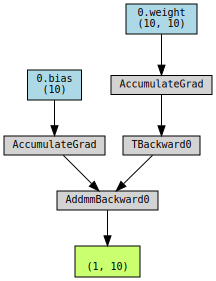

In [72]:
# Visualize the model
from torchviz import make_dot

# Create a random tensor
x = torch.randn(1, 10)

# Pass the random tensor through the model
y = test_model(x)

# Create a graph of the model
make_dot(y, params=dict(test_model.named_parameters()))